<center><font size = "10"> Week 8 - Synapses<center>
<center><font size = "8">Tutorial 03: Analysis<center>

<font size='3'><font color='blue'>In this tutorial you will see how to:
    
<font size='3'><font color='blue'>- open and plot synaptic traces from h5 files

<font size='3'><font color='blue'>- extract some parameters from the traces
    
<br><img src="Synapse_param.png" width="800" height="400">  

### Load packages and libraries to be used

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Open the file and plot

In [4]:
data = h5py.File('connection_test.h5', 'r')

print(data.keys())

<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


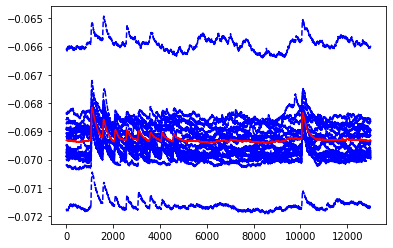

In [5]:
# Create an array with the data

connection_array = []
for v in data.keys():
    dat = data.get(v)
    dat = np.array(dat)
    connection_array.append(dat)

mean_trace = np.mean(connection_array, axis = 0)

plt.figure()
for rep in connection_array:
    plt.plot(rep, 'b--')
plt.plot(mean_trace, 'r')


### First EPSP computation of: tau rise, latency and amplitude
<font size='3'> According to [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/)

In [6]:
def amp_rise_lat_firstEPSP(sample_connection, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = False):
    """
    This function selects the rise curve (first EPSP) and find the  5, 20 and 80 % of the amplitude.
    Firstly computes the amplitude as the difference minimum - maximum in the interval (first_stimulus, max_peak).
    Secondly computes the percentages and find the times for these respective values.
    Tau_rise = 80%_time - 20%_time (Feldmeyer et al., 1999)
    latency = 5%_time - first_stimulus
    :param sample_connection: array with voltage traces oriented (voltage vs trials)(row vs column)
    :param STIM_TIMES: list with the stimuli points
    :param time: list with time steps in s
    :param t_wind_aft: time window after the stim time to compute max and min
    :param t_wind_bef: time window before the stim time to compute max and min
    :return amp_value: amplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    :return TAU_rise: list with tau_rise values in ms. Computed as the distance between the times when
    the 20 and 80 % of the rise part for the first EPSP happens
    :return latency: list with latency values in ms. Computed as the time between the AP of the presynaptic cell
    and the 5% of the first EPSP
    """
    # The analysis are performed over the mean trace
    conn = np.mean(sample_connection, axis=0)

    # save only the trace part for the first peak for voltage and time
    rise_curve = conn[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]
    rise_curve_time = time[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]

    # find max, min and compute amplitude
    max_value = np.max(rise_curve)
    min_value = np.min(rise_curve)
    amp_value_total = np.abs(max_value - min_value)

    # compute percentages
    twenty_peak_value = amp_value_total * 80.0 / 100.0
    eighty_peak_value = amp_value_total * 20.0 / 100.0
    five_peak_value = amp_value_total * 95.0 / 100.0
    amp_value = eighty_peak_value - twenty_peak_value

    # Find the exact voltage point
    twenty_curve_value = -(twenty_peak_value - max_value)
    eighty_curve_value = -(eighty_peak_value - max_value)
    five_curve_value = -(five_peak_value - max_value)

    # Find time point for the minimum
    for x, s in zip(rise_curve, rise_curve_time):
        if (x == min_value):
            min_time = s

    # Find time points for the 5, 20 and 80 % of the first EPSP
    n = 0
    m = 0
    l = 0
    for i, j in zip(rise_curve, rise_curve_time):
        if (n == 0) and (i > twenty_curve_value) and (j > min_time):
            twenty_time = j
            n = 1
        if (m == 0) and (i > eighty_curve_value) and (j > min_time):
            eighty_time = j
            m = 1
        if (l == 0) and (i > five_curve_value) and (j > min_time):
            five_time = j
            l = 1
    
    pre_AP = time[STIM_TIMES[0]]
    TAU_rise = np.abs((twenty_time-eighty_time))
    latency = np.abs((five_time)-pre_AP)

    # PLOT first EPSP with the computed points for the 5, 20 and 80 % of the first EPSP
    if PLOT == True:
        plt.figure()
        plt.plot(rise_curve_time, rise_curve, label='first EPSP')
        plt.plot(twenty_time, twenty_curve_value, 'ro', label='20%')
        plt.plot(eighty_time, eighty_curve_value, 'mo', label='80%')
        plt.plot(five_time, five_curve_value, 'go', label='5%')
        plt.legend()
        plt.show()

    return amp_value, TAU_rise, latency

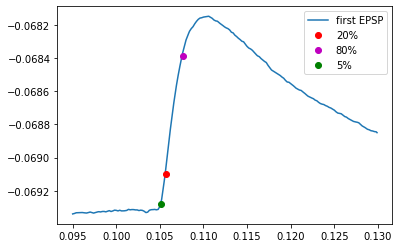

Amplitude =  -0.7139286824635049 mV
Tau_rise =  0.001899999999999999 s
latency =  0.005099999999999993 s


In [7]:
# times where a stimulus is performed
STIM_TIMES = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000]
t_wind_aft = 300 # index in the time array
t_wind_bef = 50 # index ~ ~ ~ ~ 
time = np.arange(0,1.3,0.0001)


amp_value, TAU_rise, latency = amp_rise_lat_firstEPSP(connection_array, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = True)

print('Amplitude = ', amp_value*1000.0, 'mV')
print('Tau_rise = ', TAU_rise, 's')
print('latency = ', latency, 's')

### Compute EPSP amplitudes in mV of the mean trace

In [8]:
def compute_amplitude(mean_trace, STIM_TIMES, t_wind_bef, t_wind_aft):
    """
    This function compute the amplitudes of the EPSPs in mean_trace
    :param mean_trace: deconvelved voltage data 1D-array (list)
    :param STIM_TIMES: times where a stimulus is performed
    :param t_wind_bef: time window before the stimulus
    :param t_wind_aft: time window after the stimulus 
    :return amplitudes: list with amplitude values
    """
    amplitudes = []
    max_list = []
    min_list = []
    for t in STIM_TIMES:
        mx = np.max(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        mn = np.min(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        amp = np.abs(mx - mn) 
        max_list.append(mx*1000.0) # multiply by 1000.0 to convert values to mV
        min_list.append(mn*1000.0)
        amplitudes.append(amp*1000.0)
    return max_list, min_list, amplitudes

In [9]:
max_list, min_list, amps = compute_amplitude(mean_trace, STIM_TIMES, t_wind_bef, t_wind_aft)

print('Amps = ', amps)

Amps =  [1.189881137439175, 0.6511899686994921, 0.41517863670985367, 0.3678564514432575, 0.34226299751373424, 0.3038698009082269, 0.3047620966320913, 0.275296824319024, 0.9407748778661185]
